In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [2]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
from functools import cache


def download(name, cache_dir= os.path.join('.', 'data')):
    '''下载一个DATA_HUB中的文件，返回本地文件名'''
    assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}"

    url, sha1_hash = DATA_HUB[name] # 从DATA_HUB字典中解包出文件的下载URL和SHA-1校验值
    os.makedirs(cache_dir, exist_ok= True) # 递归创建缓存目录（若目录不存在）,exist_ok=True：目录存在时不报错
    fname = os.path.join(cache_dir, url.split('/')[-1]) # 生成本地文件名（从URL提取文件名）url.split('/')[-1]：获取URL最后一部分作为文件名（如https://a/b/c.txt → c.txt）

    if os.path.exists(fname):
        # 如果本地文件已存在，计算其SHA-1哈希值
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)  # 每次读取1MB
                if not data:
                    break
                sha1.update(data)

        # 校验文件完整性，哈希匹配则直接返回缓存文件路径
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
        
    print(f'正在从{url}下载{fname}...') # 若文件不存在或哈希不匹配，则下载文件
    r = requests.get(url, stream=True, verify=True)

    # 将下载内容写入本地文件
    with open(fname, 'wb') as f:
        f.write(r.content)
    
    return fname
        

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

torch.cuda.device('cuda:1')

In [5]:
#数据

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [6]:
print(train_data.shape)
print(test_data.shape) # 测试集中没有给出售价

(1460, 81)
(1459, 80)


In [7]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [8]:
# 训练集中不要id
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [9]:
# 处理数值型数据
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 获取所有数值型数据的编号
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 将所有数据标准化，均值变为0，方差变为1
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 将所有缺失值变为0

In [10]:
# 处理离散数据（字符串），使用独热编码
all_features = pd.get_dummies(all_features, dummy_na= True)
print(all_features.shape)
print(all_features.dtypes)

(2919, 330)
MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca        bool
SaleCondition_Family        bool
SaleCondition_Normal        bool
SaleCondition_Partial       bool
SaleCondition_nan           bool
Length: 330, dtype: object


In [11]:
non_numeric_cols = all_features.select_dtypes(include=['object']).columns
print("非数值列:", non_numeric_cols)

非数值列: Index([], dtype='object')


In [12]:
# 将pandas格式转为张量
n_train = train_data.shape[0] # 训练数据的数量

all_features = all_features.astype(np.float32)
# all_feature中，前n_train是训练集，后面是测试集
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [13]:
loss = nn.MSELoss()
in_features = train_features.shape[1] # 输入特征数量

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net 

In [14]:
# 误差函数
def log_rmse(net, features, labels):
    '''使用对数来进行相对误差的比较'''
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()


In [15]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [16]:
# K折交叉验证

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.169667, 验证log rmse0.156750
折2，训练log rmse0.162065, 验证log rmse0.188759
折3，训练log rmse0.163593, 验证log rmse0.168093
折4，训练log rmse0.167927, 验证log rmse0.154490
折5，训练log rmse0.162952, 验证log rmse0.182718
5-折验证: 平均训练log rmse: 0.165241, 平均验证log rmse: 0.170162


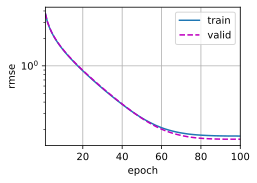

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162338


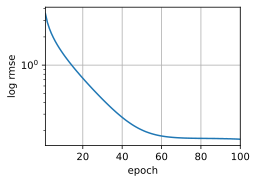

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)